# Python Course - Tutorial 9

### Exercise 1 (Data Visualization with Matplotlib)

Consider the music.db database provided in our GitHub repository. Create a histogram
that shows the distribution of the total number of items purchased per invoice. Add
appropriate axis labels, a title, and a grid to the plot. Save the plot in a designated
directory named images/ and exclude this directory from version control.

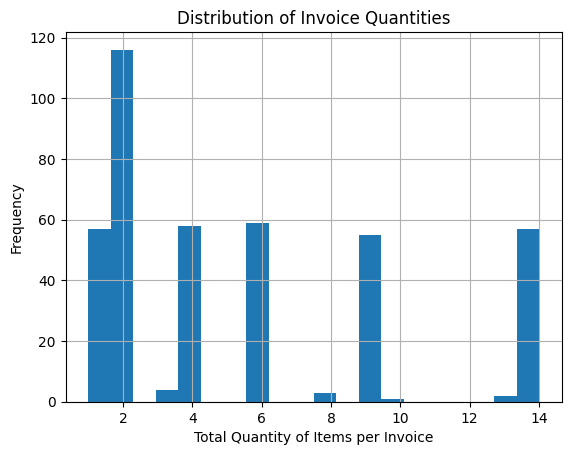

In [2]:
import pathlib
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database and read the 'invoice_items' table into a DataFrame
with sqlite3.connect("../music.db") as conn:
    invoices_items_df = pd.read_sql_query("SELECT * FROM invoice_items", conn)

# Group the data by 'InvoiceId' and calculate the total quantity of items per invoice
invoice_totals = invoices_items_df.groupby("InvoiceId")["Quantity"].sum()

# Plot a histogram of the total quantities of items per invoice
plt.hist(invoice_totals, bins=20)
plt.xlabel("Total Quantity of Items per Invoice")
plt.ylabel("Frequency")
plt.title("Distribution of Invoice Quantities")
plt.grid(True)

# Create an 'images' directory if it doesn't already exist and save the plot
pathlib.Path("images").mkdir(exist_ok=True)
plt.savefig("images/invoice_quantity_histogram.jpg")

# Display the histogram plot
plt.show()


### Exercise 2 (Linear Regression with Statsmodels)

Using the `music.db` database, investigate the relationship between track length and the number of times a track has been streamed. Treat track length (in milliseconds) as the **independent variable** and the total number of streams (from the play histories table) as the **dependent variable**.

*Note:* Since track length does not have mean zero, you should include an intercept in the model. For this, you can use `X = sm.add_constant(X, prepend=True)` before fitting the model.


                            OLS Regression Results                            
Dep. Variable:             NumStreams   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.6288
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.439
Time:                        19:32:31   Log-Likelihood:                -40.160
No. Observations:                  18   AIC:                             84.32
Df Residuals:                      16   BIC:                             86.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.0568      2.586      2.342   

C:\Users\Felix\Desktop\Studium\2024_25 Wintersemester\Hiwi Stelle - Python\python-course\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)


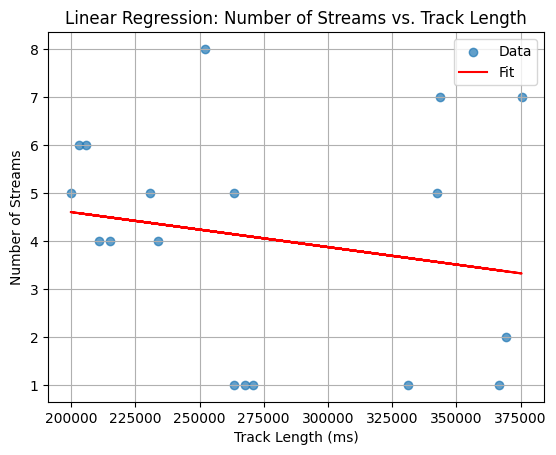

In [7]:
import statsmodels.api as sm
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database and fetch data from 'tracks' and 'play_histories' tables
conn = sqlite3.connect("../music.db")
tracks_df = pd.read_sql_query("SELECT TrackId, Milliseconds FROM tracks", conn)
play_histories_df = pd.read_sql_query("SELECT * FROM play_histories", conn)
conn.close()

# Aggregate the number of streams for each track
stream_counts = play_histories_df.groupby("TrackId").size().reset_index(name="NumStreams")

# Merge the track data with the stream counts on 'TrackId'
merged_df = pd.merge(tracks_df, stream_counts, on="TrackId", how="inner")

# Prepare the independent variable (track length) and dependent variable (number of streams)
X = merged_df["Milliseconds"].astype(float)
y = merged_df["NumStreams"].astype(float)
X = sm.add_constant(X, prepend=True)  # Add a constant term for the regression model

# Fit a linear regression model using Ordinary Least Squares (OLS)
model = sm.OLS(y, X).fit()
print(model.summary())

# Plot the data and the regression line
plt.scatter(merged_df["Milliseconds"], merged_df["NumStreams"], label="Data", alpha=0.7)
plt.plot(merged_df["Milliseconds"], model.predict(X), color="red", label="Fit")

# Label the axes, add a title, grid, and legend to the plot
plt.xlabel("Track Length (ms)")
plt.ylabel("Number of Streams")
plt.title("Linear Regression: Number of Streams vs. Track Length")
plt.grid()
plt.legend()
plt.show()


### Exercise 3 (Statistical Analysis with SciPy)

The `northwind` database from our GitHub repository contains unit price and category information for various products. Write a function that takes two category names as input and performs a **t-test** to determine if the mean product unit prices of the two categories are significantly different. The function should return a boolean value indicating whether the difference is significant at a **95% confidence level** (i.e., whether the p-value is less than 0.05).


In [8]:
import sqlite3
import pandas as pd
from scipy import stats

def has_significant_price_differences(category1, category2):
    # Connect to the SQLite database and fetch data from 'Products' and 'Categories' tables
    with sqlite3.connect("data/northwind.db") as conn:
        products_df = pd.read_sql_query("SELECT * FROM Products", conn)
        categories_df = pd.read_sql_query("SELECT * FROM Categories", conn)

    # Merge the products and categories data on 'CategoryID'
    merged_df = pd.merge(products_df, categories_df, on="CategoryID", how="inner")

    # Extract prices for the specified categories
    cat1_prices = merged_df.loc[merged_df["CategoryName"] == category1, "UnitPrice"]
    cat2_prices = merged_df.loc[merged_df["CategoryName"] == category2, "UnitPrice"]

    # Perform an independent t-test to compare the two categories
    t_stat, p_val = stats.ttest_ind(cat1_prices, cat2_prices)

    # Print the test statistics and interpret the result
    print("T-statistic:", round(t_stat, 4))
    print("P-value:", round(p_val, 4))
    if p_val < 0.05:
        print("Reject null hypothesis: The means are different")
        return True
    else:
        print("Fail to reject null hypothesis: The means are the same")
        return False

# Check for significant price differences between two categories
result = has_significant_price_differences("Beverages", "Condiments")
print(result)


T-statistic: 0.7132
P-value: 0.4832
Fail to reject null hypothesis: The means are the same
False


### Exercise 4 (Sharpe Ratio Comparison)
In the field of finance, the **Sharpe Ratio** is a common metric used to understand how well an investment performs relative to its risk. Formally, the Sharpe Ratio is calculated as:

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

where:  
- $R_p$ is the expected return (often taken as the mean return of the asset over a given period).  
- $R_f$ is the risk-free rate (a theoretical return of an investment with zero risk, often approximated by government bonds).  
- $\sigma_p$ is the standard deviation (volatility) of the asset’s returns.

A higher Sharpe Ratio indicates that the investment is providing a higher return per unit of risk.

---

**In the lecture you have downloaded:**

1. **SP500_Total_Return.csv**: Historical data for the S&P 500 Total Return Index  
2. **DAX.csv**: Historical data for the DAX Index  

**Your tasks are to:**  

(i) Load both datasets from the CSV files into Pandas DataFrames.  

(ii) Compute the daily returns for each index (use e.g., Pandas `pct_change()` method).  

(iii) Assume a **constant annualized risk-free rate of 2%** for this analysis. (In practice, you might load this from a dataset or a more appropriate proxy.)  

(iv) Compute the annualized Sharpe Ratio for each index using:

$$
\text{Sharpe Ratio (annualized)} = \frac{(\text{mean daily return} - \text{daily risk-free rate}) \times 252}{\text{daily return volatility} \times \sqrt{252}}
$$

Here, $252$ represents the approximate number of trading days in a year.

(v) Print out the Sharpe Ratio for both the S&P 500 Total Return and the DAX, and compare which one has a higher risk-adjusted return.

**Note:** If a particular index has no data or returns are NaN, handle it gracefully and report that the Sharpe Ratio cannot be computed.

In [14]:
import pandas as pd
import numpy as np

# (i) Load the CSV files into DataFrames
sp500_df = pd.read_csv("../examples/data/SP500_Total_Return.csv", parse_dates=["Date"], index_col="Date")
dax_df = pd.read_csv("../examples/data/DAX.csv", parse_dates=["Date"], index_col="Date")

# (ii) Compute daily returns
sp500_df["Daily_Return"] = sp500_df["Adj Close"].pct_change()
dax_df["Daily_Return"] = dax_df["Adj Close"].pct_change()

# (iii) Assume an annualized risk-free rate of 2%
annual_rf = 0.02
# Convert annual risk-free rate to daily
daily_rf = (1 + annual_rf)**(1/252) - 1

# (iv) Compute Sharpe Ratios
def compute_annualized_sharpe_ratio(returns, daily_risk_free):
    # Drop NaN values
    returns = returns.dropna()
    if len(returns) == 0:
        return np.nan
    mean_daily = returns.mean()
    daily_vol = returns.std()
    # Annualized Sharpe Ratio
    sharpe_ratio = ((mean_daily - daily_risk_free) * 252) / (daily_vol * np.sqrt(252))
    return sharpe_ratio

sp500_sharpe = compute_annualized_sharpe_ratio(sp500_df["Daily_Return"], daily_rf)
dax_sharpe = compute_annualized_sharpe_ratio(dax_df["Daily_Return"], daily_rf)

# (v) Print out and compare
print("S&P 500 Total Return Sharpe Ratio:", round(sp500_sharpe, 4))
print("DAX Sharpe Ratio:", round(dax_sharpe, 4))
if pd.isna(sp500_sharpe):
    print("Cannot compute Sharpe Ratio for S&P 500 Total Return")
if pd.isna(dax_sharpe):
    print("Cannot compute Sharpe Ratio for DAX")
if not pd.isna(sp500_sharpe) and not pd.isna(dax_sharpe):
    if sp500_sharpe > dax_sharpe:
        print("S&P 500 Total Return has a higher risk-adjusted return.")
    else:
        print("DAX has a higher risk-adjusted return.")


S&P 500 Total Return Sharpe Ratio: 0.3879
DAX Sharpe Ratio: 0.22
S&P 500 Total Return has a higher risk-adjusted return.


### Exercise 5 (Optional: Additional Python Resources for Data Science)

To further strengthen your skills in Python for data analysis and visualization, consider completing the following tasks:

1. **Discover Additional Resources for Popular Python Packages**:  
   - Read parts of [Python for Data Analysis](https://wesmckinney.com/book/) by Wes McKinney to enhance your knowledge of Pandas and NumPy for data manipulation.  
   - Check out [The Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) by Jake VanderPlas, which covers essential tools like Matplotlib, SciPy, and Scikit-learn.  
   - Review the [Matplotlib Cookbook](https://github.com/rougier/scientific-visualization-book) for hands-on examples of data visualization with Matplotlib.  
   - Explore the documentation for [Seaborn](https://seaborn.pydata.org/) (for advanced statistical plots) and [Plotly](https://plotly.com/python/) (for interactive, web-based visualizations).  
   - Visit [Claus Wilke's Data Visualization](https://clauswilke.com/dataviz/) for advice on creating effective visualizations.  
   - Dive into the [Scientific Python Lectures](https://lectures.scientific-python.org/) to deepen your understanding of Python in scientific computing.  

2. **Practice and Apply Your Skills**:  
   - Challenge yourself with Python exercises using NumPy and Pandas on platforms like [StrataScratch](https://www.stratascratch.com), which offers real-world datasets and interview questions.  
   - Explore practical problems and datasets on [Kaggle](https://www.kaggle.com).  

3. **Choose Your Own Project**:  
   - Alternatively, pick a project or topic that interests you and apply the concepts you've learned to it.
